# RE:从零开始的卷积神经网络

## 从全链接到卷积

### 两大假设

(1) 平移不变性：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对应相同的图像区域具有相似的反应，即“平移不变性”

(2) 局部性： 神经网络前面的几层应该只探索输入图像中的局部区域，而不是过度在意图像中相隔较远区域的关系。

### 多层感知机的限制

设多层感知机的输入是二维图像$X$,其隐藏表示$H$在数学上是一个矩阵，在代码中表示为二维张量。$X$和$H$具有相同的形状。

使用$[X]_{i,j}$和$[H]_{i,j}$分别表示输入图像和隐藏表示中位置$(i,j)$处的像素。为了使每个隐藏神经元都能接收每个输入像素的信息，我们将参数从权重矩阵替换为四阶权重张量$W$,假设$U$包含偏置参数，我们可以将全连接层形式化地表示为：

$$
[H]_{i,j} = [U]_{i,j} + \sum_k \sum_l [W]_{i,j,k,l} [X]_{k,l} 
          = [U]_{i,j} + \sum_a \sum_b [V]_{i,j,a,b} [X]_{i+a,j+b}
$$

其中，从$W$到$V$的转换只是形式上的转换

#### 平移不变性：

即$ [V]_{i,j,a,b} = [V]_{a,b}$且$U$是一个常数

$$ [H]_{i,j} = u + \sum_{a} \sum_{b} [V]_{a,b} [X]_{i+a,j+b} $$

#### 局部性：

即在$|a|>\Delta$或$|b|>\Delta$的范围，我们可以设置$[V]_{a,b}=0$因此我们可以将$[H]_{i,j}$重写

$$ [H]_{i,j} = u + \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} [V]_{a,b} [X]_{i+a,j+b}$$

现在我们得到了卷积层。$V$称之为卷积核或滤波器

### 卷积

#### 什么是卷积？

设两个函数($f, g: \mathbb{R}^d \to \mathbb{R}$)，则卷积为

$$(f*g)(x) = \int f(z)g(x-z)dz $$

当为离散对象时，积分便是求和

$$(f*g)(i) = \sum_{a} f(a)g(i-a) $$

对于二维张量，则为$f$的索引$(a,b)$和$g$的索引$(i-a,j-b)$上的对应加和

$$(f*g)(i,j) = \sum_{a} \sum_{b} f(a,b)g(i-a,j-b) $$

## 图像卷积

### 互相关运算

严格来说，卷积层并非卷积，而是互相关运算

![image](http://zh.gluon.ai/_images/correlation.svg)

设计corr2d函数，接收输入张量X和卷积核张量K,并返回输出张量Y

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X,K):  #@save
    h,w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1 , X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层

In [4]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self,X):
        return corr2d(x,self.weight) + self.bias

### 图像中目标的边缘检测

In [5]:
X = torch.ones((6,8))
X[:,2:6]=0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [8]:
K = torch.tensor([[1.0,-1.0]])

In [9]:
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [10]:
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 学习卷积层

In [12]:
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias = False)

X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y)**2
    conv2d.zero_grad()
    l.sum().backward()

    conv2d.weight.data[:] -=lr*conv2d.weight.grad
    if(i+1)%2 == 0:
        print(f'epoch {i+1},loss {l.sum() :.3f}')

epoch 2,loss 10.238
epoch 4,loss 2.342
epoch 6,loss 0.649
epoch 8,loss 0.214
epoch 10,loss 0.079


In [13]:
conv2d.weight.data.reshape((1,2))

tensor([[ 1.0134, -0.9578]])

## 填充和步幅

### 填充

![image](http://zh.gluon.ai/_images/conv_pad.svg)

一般来说，如果在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，那么输出形状将会是

$$(nh−kh+ph+1)×(nw−kw+pw+1)$$,
也就是说，输出的高和宽会分别增加$p_h$和$p_w$。

在很多情况下，我们会设置$p_h=k_h−1$和$p_w=k_w−1$来使输入和输出具有相同的高和宽。这样会方便在构造网络时推测每个层的输出形状。假设这里$k_h$是奇数，我们会在高的两侧分别填充$p_h/2$行。如果$k_h$是偶数，一种可能是在输入的顶端一侧填充$⌈ph/2⌉$行，而在底端一侧填充$⌊ph/2⌋$行。在宽的两侧填充同理。

卷积神经网络经常使用奇数高和宽的卷积核，如1、3、5和7，所以两端上的填充个数相等。对任意的二维数组X，设它的第i行第j列的元素为$X[i,j]$。当两端上的填充个数相等，并使输入和输出具有相同的高和宽时，我们就知道输出$Y[i,j]$是由输入以$X[i,j]$为中心的窗口同卷积核进行互相关计算得到的。

In [16]:
import torch
from torch import nn

def comp_conv2d(conv2d,X):
    X = X.reshape((1,1)+ X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1,1,kernel_size =3,padding=1)
X = torch.rand(size = (8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

### 步幅

![image](http://zh.gluon.ai/_images/conv_stride.svg)

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为:
$$⌊(n_h−k_h+p_h+s_h)/s_h⌋×⌊(n_w−k_w+p_w+s_w)/s_w⌋$$
如果设置$p_h=k_h−1$和$p_w=k_w−1$，那么输出形状将简化为$⌊(n_h+s_h−1)/s_h⌋×⌊(n_w+s_w−1)/s_w⌋$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h/s_h)×(n_w/s_w)$。

下面我们令高和宽上的步幅均为2，从而使输入的高和宽减半。

In [17]:
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [18]:
conv2d = nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

## 多输入多输出通道

### 多输入通道

![image](http://zh.gluon.ai/_images/conv_multi_in.svg)

In [19]:
import torch
from d2l import torch as d2l

In [60]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [61]:
X = torch.tensor([[[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]],
                 [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]])
K = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[1.0,2.0],[3.0,4.0]]])

corr2d_multi_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道

当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1。设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i×k_h×k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_o×c_i×k_h×k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

In [70]:
def corr2d_multi_in_out(X, K):
    # 遍历输出通道的核
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [71]:
K = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[1.0,2.0],[3.0,4.0]]])

In [72]:
K.shape

torch.Size([2, 2, 2])

In [74]:
K = torch.stack((K,K+1,K+2),0)
K.shape

torch.Size([3, 2, 2, 2])

In [75]:
corr2d_multi_in_out(X,K)

tensor([[[ -8.3810,  -0.3413],
         [-15.4726,   2.2035]],

        [[-10.9766,   0.2405],
         [-22.4220,   0.8978]],

        [[-13.5722,   0.8223],
         [-29.3715,  -0.4080]]])

### $1 \times 1 卷积层$ 

![image](http://zh.gluon.ai/_images/conv_1x1.svg)

最后我们讨论卷积窗口形状为$1×1$（$k_h=k_w=1$）的多通道卷积层。我们通常称之为$1×1$卷积层，并将其中的卷积运算称为$1×1$卷积。因为使用了最小窗口，$1×1$卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，$1×1$卷积的主要计算发生在通道维上。上面展示了使用输入通道数为$3$、输出通道数为$2$的$1×1$卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1×1$卷积层的作用与全连接层等价。

In [76]:
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i,h*w))
    K = K.reshape((c_o,c_i))

    Y = torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [77]:
X = torch.normal(0,1,(3,3,3))
K = torch.normal(0,1,(2,3,1,1))

In [78]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X,K)
Y1

tensor([[[ 0.0114,  1.2650,  0.2619],
         [-1.1796,  0.4401, -2.3122],
         [-1.1415, -0.0714, -0.9394]],

        [[ 0.0250,  0.1993,  0.0287],
         [ 0.0559, -0.0460,  0.4461],
         [-0.0121,  0.4306, -0.3953]]])

In [79]:
Y2

tensor([[[ 0.0114,  1.2650,  0.2619],
         [-1.1796,  0.4401, -2.3122],
         [-1.1415, -0.0714, -0.9394]],

        [[ 0.0250,  0.1993,  0.0287],
         [ 0.0559, -0.0460,  0.4461],
         [-0.0121,  0.4306, -0.3953]]])

## 汇聚层

它的提出是为了缓解卷积层对位置的过度敏感性

### 最大汇聚和平均汇聚

同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出。不同于卷积层里计算输入和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

![image](http://zh.gluon.ai/_images/pooling.svg)

如图展示了池化窗口形状为$2×2$的最大池化，阴影部分为第一个输出元素及其计算所使用的输入元素。输出数组的高和宽分别为2，其中的4个元素由取最大值运算max得出：
$$
\max(0,1,3,4)= 4
$$
$$
\max(1,2,4,5)= 5
$$
$$
\max(3,4,6,7)= 7
$$
$$
\max(4,5,7,8)= 8
$$

二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

现在我们将卷积层的输出作为$2\times 2$最大池化的输入。设该卷积层输入是$X$、池化层输出为$Y$。无论是$X[i, j]$和$X[i, j+1]$值不同，还是X$[i, j+1]$和$X[i, j+2]$不同，池化层输出均有$Y[i, j]=1$。也就是说，使用$2\times 2$最大池化层时，只要卷积层识别的模式在高和宽上移动不超过一个元素，我们依然可以将它检测出来。

In [80]:
import torch
from torch import nn
from d2l import torch as d2l

In [83]:
def pool2d(X,pool_size,mode='max'):
    p_h,p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max' :
                Y[i,j] = X[i:i+p_h,j:j+p_w].max()
            elif mode =='avg':
                Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return Y

In [84]:
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [85]:
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

### 填充和步幅

In [86]:
X = torch.arange(16,dtype=torch.float32).reshape((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [87]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [88]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [89]:
pool2d = nn.MaxPool2d((2,3),stride=(2,3),padding=(0,1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 多个通道

In [90]:
X = torch.cat((X,X+1),1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [91]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 卷积神经网络（LeNet）

### LeNet

总体来看，LeNet（LeNet-5）由两个部分组成：

- 卷积编码器：由两个卷积层组成;

- 全连接层密集块：由三个全连接层组成。

![image](https://zh-v2.d2l.ai/_images/lenet.svg)

In [92]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

<div style="text-align: center;">
    <img src="https://zh-v2.d2l.ai/_images/lenet-vert.svg" alt="LeNet 架构图" style="width: 20%;">
</div>

In [93]:
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape : \t',X.shape)

Conv2d output shape : 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape : 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape : 	 torch.Size([1, 6, 14, 14])
Conv2d output shape : 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape : 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape : 	 torch.Size([1, 16, 5, 5])
Flatten output shape : 	 torch.Size([1, 400])
Linear output shape : 	 torch.Size([1, 120])
Sigmoid output shape : 	 torch.Size([1, 120])
Linear output shape : 	 torch.Size([1, 84])
Sigmoid output shape : 	 torch.Size([1, 84])
Linear output shape : 	 torch.Size([1, 10])


### 模型训练

In [94]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)

In [98]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [99]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.470, train acc 0.822, test acc 0.813
4118.9 examples/sec on cpu


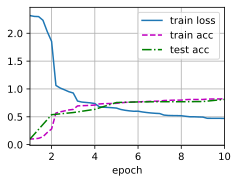

In [100]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())